# Pick particles with crYOLO

This example covers [crYOLO Tutorial 2](https://cryolo.readthedocs.io/en/stable/tutorials/tutorial_overview.html#tutorial-2-pick-particles-by-training-a-model-for-your-data), using particle picks from CryoSPARC as training data. The crYOLO GUI is not required for this tutorial.

To run this notebook, set up a conda environment as directed in the [Running Example Notebooks](running-the-examples) instructions (be sure to run the optional crYOLO installation commands).

## Prelude

Connect to a cryoSPARC instance with `cryosparc.tools.CryoSPARC` and get the project handle. This project contains a workspace `W3` with the following jobs:

* Patch CTF with 20 motion-corrected and CTF-estimated micrographs
* Exposures Sets tool that splits micrographs into 5 for training/validation and 15 for picking from the trained model
* Manual Picker that picks 5 training micrographs to completion

```{note}
Saving crYOLO outputs to the CryoSPARC project directory requires file-system access to the project directory.
```

In [1]:
from cryosparc.tools import CryoSPARC

cs = CryoSPARC(host="cryoem0.sbi", base_port=40000)
assert cs.test_connection()

project = cs.find_project("P377")

Connection succeeded to CryoSPARC API at http://cryoem0.sbi:40002


Programatically create and build a new external job. This job will contain the results of both training and picking for the remaining micrographs.

Use the `job.connect` function to connect the training picks, training micrographs and remaining micrographs as inputs. This function has the following signature:

```py
connect(
    target_input: str,
    source_job_uid: str,
    source_output: str,
    slots: list[SlotSpec] = [],
    title: str = "",
    desc: str = "",
)
```

Where,

- `target_input` is the name of the input to create on the new job, e.g., `"train_particles"`
- `source_job_uid` is the unique ID of the parent job to connect for this input, e.g., `"J42"`
- `source_output` is the name of the output on the parent job
- `slots` (optional) is a list of required results in the parent output.

Specify `micrograph_blob` as slots for the micrographs to retrieve the motion-corrected micrograph path. Other micrograph slots will be connected as passthroughs. Specify the `location` slot to retrieve the $(x, y)$ coordinates for each particle in their original micrograph.

Create an output slots for the resulting picks. It must inlude `location` and
`pick_stats` slots


In [2]:
job = project.create_external_job("W3", title="crYOLO Picks")
job.connect("train_micrographs", "J47", "split_0", slots=["micrograph_blob"])
job.connect("train_particles", "J27", "particles_selected", slots=["location"])
job.connect("all_micrographs", "J47", "split_0", slots=["micrograph_blob"])
job.connect("all_micrographs", "J47", "remainder", slots=["micrograph_blob"])
job.add_output("particle", "predicted_particles", slots=["location", "pick_stats"])

'predicted_particles'

Read the [Jobs Guide](../guides/jobs.ipynb) for instructions on inspecting job outputs to determine their names and available slots for use in this connection step.

Start the job to write to the outputs and job log. This puts the job in "Waiting" status.

In [3]:
job.start()

## Data Preparation

Use the job directory as crYOLO's working directory. Create all the necessary subfolders there.

In [4]:
job.mkdir("full_data")
job.mkdir("train_image")
job.mkdir("train_annot")

Load the input micrographs and link them into the `full_data` and `train_image` directories. This results in the following directory structure:

```
/path/to/project/JX/
├── full_data
│   ├── mic01.mrc -> /path/to/project/JY/motioncorrected/mic01.mrc
│   ├── mic02.mrc -> /path/to/project/JY/motioncorrected/mic02.mrc
│   ├── ...
│   └── mic20.mrc -> /path/to/project/JY/motioncorrected/mic20.mrc
└── train_image
    ├── mic01.mrc -> /path/to/project/JY/motioncorrected/mic01.mrc
    ├── mic02.mrc -> /path/to/project/JY/motioncorrected/mic02.mrc
    ├── mic03.mrc -> /path/to/project/JY/motioncorrected/mic03.mrc
    ├── mic04.mrc -> /path/to/project/JY/motioncorrected/mic04.mrc
    └── mic05.mrc -> /path/to/project/JY/motioncorrected/mic05.mrc
```

In [5]:
all_micrographs = job.load_input("all_micrographs", ["micrograph_blob"])
train_micrographs = job.load_input("train_micrographs", ["micrograph_blob"])

for mic in all_micrographs.rows():
    source = mic["micrograph_blob/path"]
    target = job.uid + "/full_data/"
    project.symlink(source, target)

for mic in train_micrographs.rows():
    source = mic["micrograph_blob/path"]
    target = job.uid + "/train_image/"
    project.symlink(source, target)

crYOLO requires the particle locations for each micrograph in STAR format with the following directory stucture:

```
/path/to/project/JX/
└── train_annot
    └── STAR
        ├── mic01.star
        ├── mic02.star
        ├── mic03.star
        ├── mic04.star
        └── mic05.star

```

Load the training particle locations. Split them up my micrograph path. Compute the pixel locations and save them to a star file in this format.

In [6]:
from io import StringIO

import numpy as np

from cryosparc import star

job.mkdir("train_annot/STAR")
train_particles = job.load_input("train_particles", ["location"])

for micrograph_path, particles in train_particles.split_by("location/micrograph_path").items():
    micrograph_name = micrograph_path.split("/")[-1]
    star_file_name = micrograph_name.rsplit(".", 1)[0] + ".star"

    mic_w = particles["location/micrograph_shape"][:, 1]
    mic_h = particles["location/micrograph_shape"][:, 0]
    center_x = particles["location/center_x_frac"]
    center_y = particles["location/center_y_frac"]
    location_x = center_x * mic_w
    location_y = center_y * mic_h

    outfile = StringIO()
    star.write(
        outfile,
        np.rec.array([location_x, location_y], names=["rlnCoordinateX", "rlnCoordinateY"]),
    )
    outfile.seek(0)
    job.upload("train_annot/STAR/" + star_file_name, outfile)

Preview of the particle locations used on the last training micrograph:

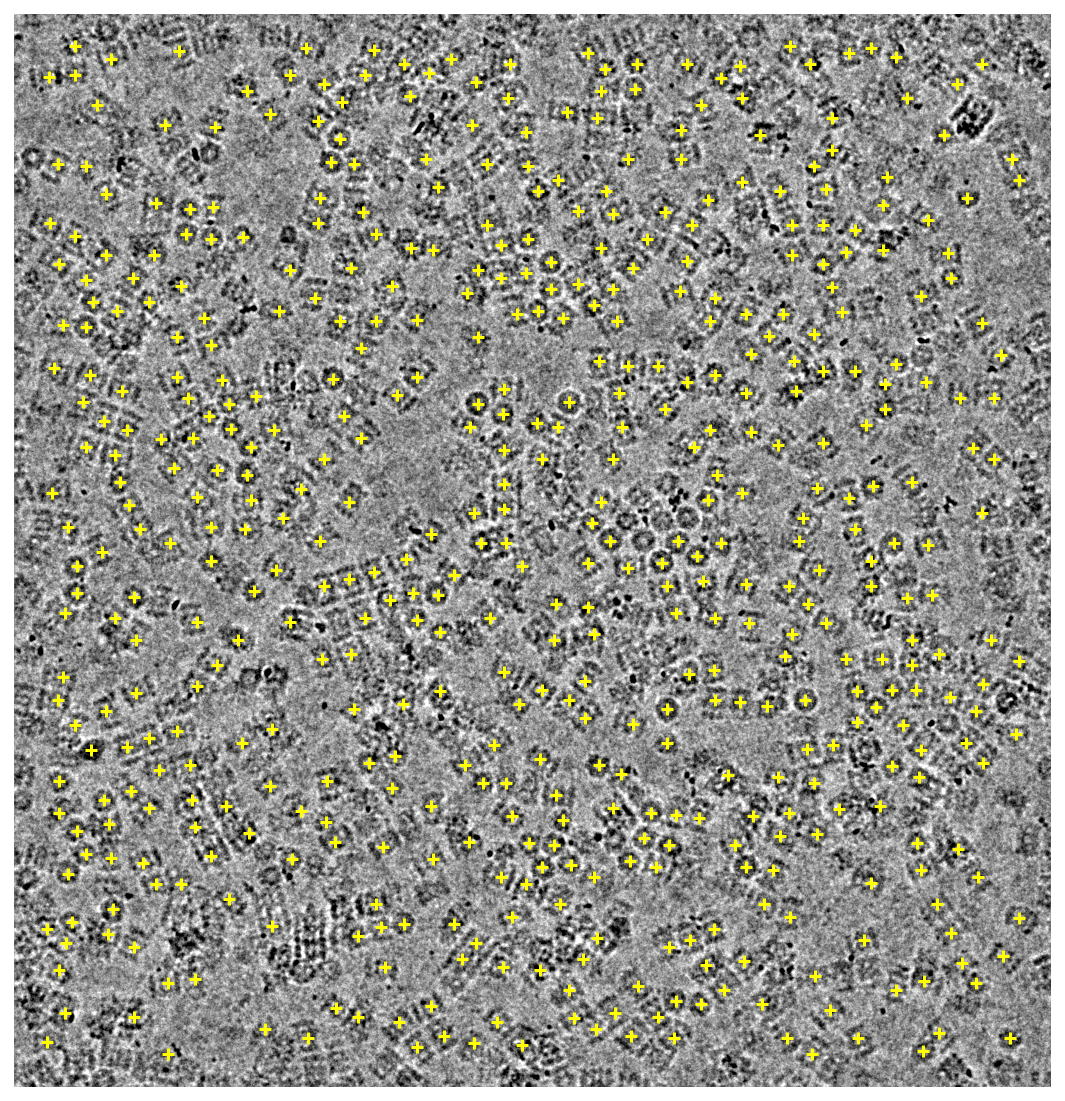

In [7]:
%matplotlib inline

import matplotlib.pyplot as plt

from cryosparc.tools import downsample, lowpass2

header, mic = project.download_mrc(micrograph_path)
binned = downsample(mic, factor=3)
lowpassed = lowpass2(binned, psize_A=0.6575, cutoff_resolution_A=20, order=0.7)
height, width = lowpassed.shape
vmin = np.percentile(lowpassed, 1)
vmax = np.percentile(lowpassed, 99)

fig, ax = plt.subplots(figsize=(7.5, 8), dpi=144)
ax.axis("off")
ax.imshow(lowpassed, cmap="gray", vmin=vmin, vmax=vmax, origin="lower")
ax.scatter(center_x * width, center_y * height, c="yellow", marker="+")

fig.tight_layout()

## Configuration

cryosparc-tools provides a `job.subprocess` function to run arbitrary processes, including `cryolo_*.py` scripts installed in the active conda environment.

Use `job.subprocess` to generate a crYOLO configuration file with the `cryolo_gui.py config` command. Specify a box size of 130 for this dataset.

```{note}
When connecting to a remote CryoSPARC instance, note that `job.subprocess` processes will run on the local machine, not remotely.
```

In [8]:
job.subprocess(
    (
        "cryolo_gui.py config config_cryolo.json 130 --train_image_folder train_image --train_annot_folder train_annot"
    ).split(" "),
    cwd=job.dir(),
)

#####################################################
Important debugging information.
In case of any problems, please provide this information.
#####################################################
/u/nfrasser/micromamba/envs/cryosparc-tools-example/bin/cryolo_gui.py config config_cryolo.json 130
--train_image_folder train_image
--train_annot_folder train_annot
#####################################################

 Wrote config to config_cryolo.json


`job.subprocess` also forwards the output to the job stream log. Arguments such as `cwd` are similar to Python's [`subprocess.Popen()`](https://docs.python.org/3/library/subprocess.html#subprocess.Popen).

This results in a `config_cryolo.json` configuration file in the external job directory.

## Training

Run training on GPU 0 with 5 warmup-epochs and an early stop of 15.

The output of this command is quite long, so set `mute=True` to hide it (it will still appear in the job's Event log).

Use the `checkpoint_line_pattern` flag new training epoch lines as the beginning of a checkpoint in the Event log.

In [9]:
job.subprocess(
    "cryolo_train.py -c config_cryolo.json -w 5 -g 0 -e 15".split(" "),
    cwd=job.dir(),
    mute=True,
    checkpoint=True,
    checkpoint_line_pattern=r"Epoch \d+/\d+",  # e.g., "Epoch 42/200"
)

Open the External job's "Events" tab from CryoSPARC's web interface to view crYOLO's output. When the process completes, crYOLO creates a `cryolo_model.h5` trained model file in the job directory.

## Picking

Use the trained model to predict particle locations for the full dataset. Create a `boxfiles` directory to store the output.

In [10]:
job.mkdir("boxfiles")
job.subprocess(
    "cryolo_predict.py -c config_cryolo.json -w cryolo_model.h5 -i full_data -g 0 -o boxfiles -t 0.3".split(" "),
    cwd=job.dir(),
    mute=True,
    checkpoint=True,
)

For each micrograph in the full dataset, load the corresponding output particles star file, initialize a new empty particles dataset and fill in the predicted locations and other relevant location metadata.

Also fill in a dummy NCC score so that the results may be inspected with an Inspect Picks job.

In [11]:
output_star_folder = "STAR"

all_predicted = []
for mic in all_micrographs.rows():
    micrograph_path = mic["micrograph_blob/path"]
    micrograph_name = micrograph_path.split("/")[-1]
    height, width = mic["micrograph_blob/shape"]

    starfile_name = micrograph_name.rsplit(".", 1)[0] + ".star"
    starfile_path = "boxfiles/STAR/" + starfile_name
    locations = star.read(job.dir() / starfile_path)[""]
    center_x = locations["rlnCoordinateX"] / width
    center_y = locations["rlnCoordinateY"] / height

    predicted = job.alloc_output("predicted_particles", len(locations))
    predicted["location/micrograph_uid"] = mic["uid"]
    predicted["location/micrograph_path"] = mic["micrograph_blob/path"]
    predicted["location/micrograph_shape"] = mic["micrograph_blob/shape"]
    predicted["location/micrograph_psize_A"] = mic["micrograph_blob/psize_A"]
    predicted["location/center_x_frac"] = center_x
    predicted["location/center_y_frac"] = center_y
    predicted["pick_stats/ncc_score"] = 0.5

    all_predicted.append(predicted)

Output the most recent predicted particle locations to verify that crYOLO ran successfully.

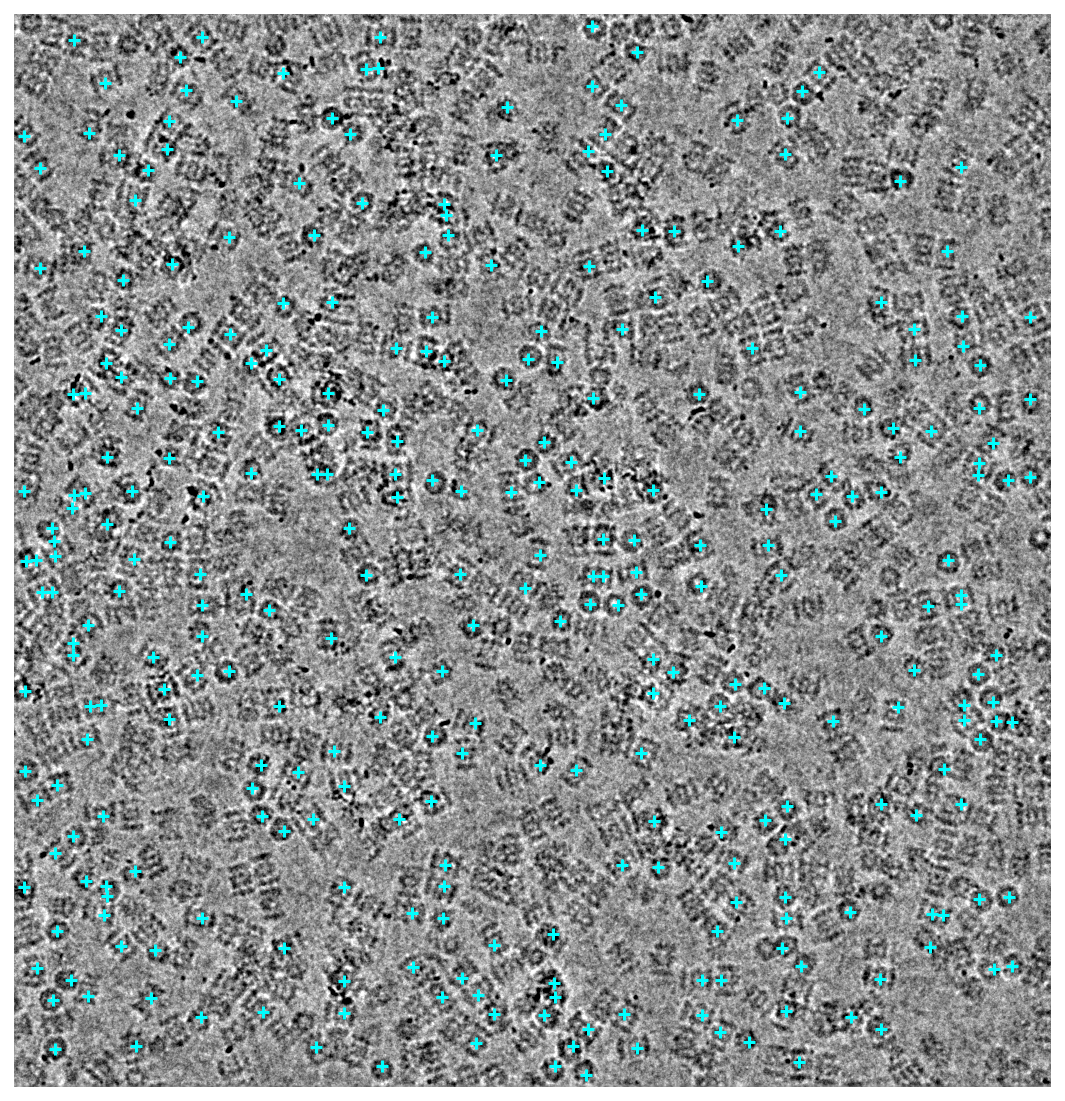

In [12]:
header, mic = project.download_mrc(micrograph_path)
binned = downsample(mic, factor=3)
lowpassed = lowpass2(binned, psize_A=0.6575, cutoff_resolution_A=20, order=0.7)
height, width = lowpassed.shape
vmin = np.percentile(lowpassed, 1)
vmax = np.percentile(lowpassed, 99)

fig, ax = plt.subplots(figsize=(7.5, 8), dpi=144)
ax.axis("off")
ax.imshow(lowpassed, cmap="gray", vmin=vmin, vmax=vmax, origin="lower")
ax.scatter(center_x * width, center_y * height, c="cyan", marker="+")

fig.tight_layout()

Append all the predicted particles into a single dataset. Save this to the job and mark as completed.

In [13]:
from cryosparc.dataset import Dataset

job.save_output("predicted_particles", Dataset.append(*all_predicted))
job.stop()